<a href="https://colab.research.google.com/github/AryanGupta5084/Fine/blob/main/Multi_class_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch, os
import pandas as pd
from transformers import pipeline, BertForSequenceClassification, BertTokenizerFast
from torch.utils.data import Dataset

In [ ]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
pip install pandas

In [ ]:
import pandas as pd
df_org= pd.read_csv("g.csv")
df_org.head()

,flags,utterance,category,intent
0,BM,I have problems with canceling an order,ORDER,cancel_order
1,BIM,how can I find information about canceling ord...,ORDER,cancel_order
2,B,I need help with canceling the last order,ORDER,cancel_order
3,BIP,could you help me cancelling the last order I ...,ORDER,cancel_order
4,B,problem with cancelling an order I made,ORDER,cancel_order


In [ ]:
labels = df_org['category'].unique().tolist()
labels = [s.strip() for s in labels ]
labels

['ORDER',
 'SHIPPING_ADDRESS',
 'CANCELLATION_FEE',
 'INVOICE',
 'PAYMENT',
 'REFUND',
 'FEEDBACK',
 'CONTACT',
 'ACCOUNT',
 'DELIVERY',
 'NEWSLETTER']

In [ ]:
for key, value in enumerate(labels):
    print(value)

ORDER
SHIPPING_ADDRESS
CANCELLATION_FEE
INVOICE
PAYMENT
REFUND
FEEDBACK
CONTACT
ACCOUNT
DELIVERY
NEWSLETTER


In [ ]:

NUM_LABELS= len(labels)

id2label={id:label for id,label in enumerate(labels)}

label2id={label:id for id,label in enumerate(labels)}

In [ ]:
label2id

{'ORDER': 0,
 'SHIPPING_ADDRESS': 1,
 'CANCELLATION_FEE': 2,
 'INVOICE': 3,
 'PAYMENT': 4,
 'REFUND': 5,
 'FEEDBACK': 6,
 'CONTACT': 7,
 'ACCOUNT': 8,
 'DELIVERY': 9,
 'NEWSLETTER': 10}

In [ ]:
id2label

{0: 'ORDER',
 1: 'SHIPPING_ADDRESS',
 2: 'CANCELLATION_FEE',
 3: 'INVOICE',
 4: 'PAYMENT',
 5: 'REFUND',
 6: 'FEEDBACK',
 7: 'CONTACT',
 8: 'ACCOUNT',
 9: 'DELIVERY',
 10: 'NEWSLETTER'}

In [ ]:
df_org.drop(columns=['flags','intent'],inplace=True)
df_org.head()

,utterance,category
0,I have problems with canceling an order,ORDER
1,how can I find information about canceling ord...,ORDER
2,I need help with canceling the last order,ORDER
3,could you help me cancelling the last order I ...,ORDER
4,problem with cancelling an order I made,ORDER


In [ ]:
df_org["labels"]=df_org.category.map(lambda x: label2id[x.strip()])

In [ ]:
df_org.head()

,utterance,category,labels
0,I have problems with canceling an order,ORDER,0
1,how can I find information about canceling ord...,ORDER,0
2,I need help with canceling the last order,ORDER,0
3,could you help me cancelling the last order I ...,ORDER,0
4,problem with cancelling an order I made,ORDER,0


<Axes: ylabel='count'>

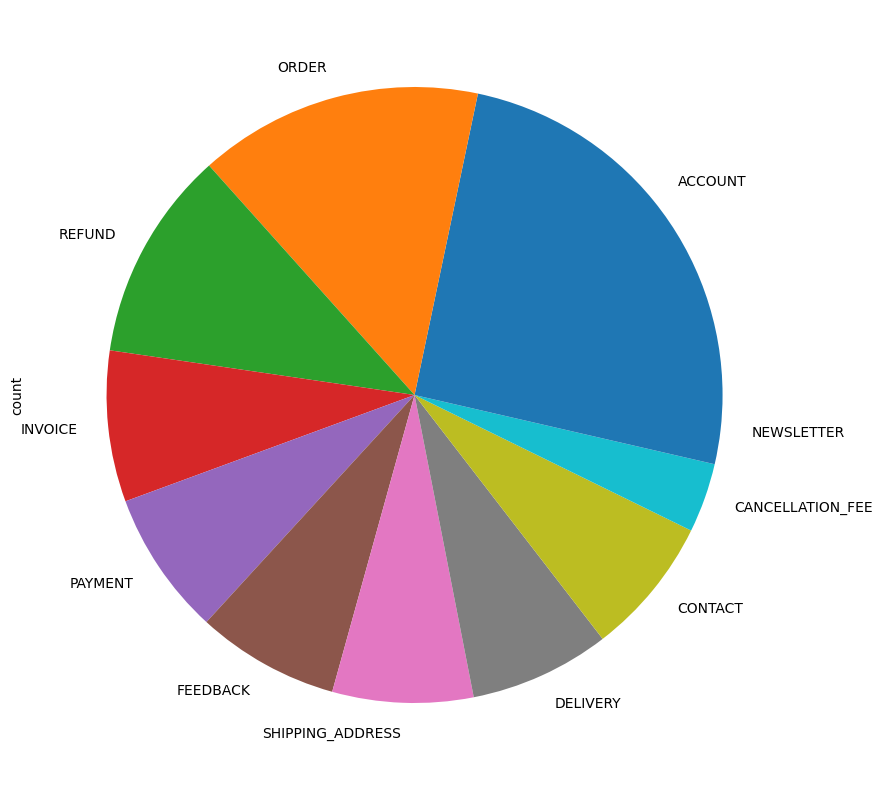

In [ ]:
df_org.category.value_counts().plot(kind='pie', figsize=(10,10))

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained("dbmdz/bert-base-turkish-uncased", max_length=512)

In [ ]:
model = BertForSequenceClassification.from_pretrained("dbmdz/bert-base-turkish-uncased", num_labels=NUM_LABELS, id2label=id2label, label2id=label2id)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
SIZE= df_org.shape[0]

train_texts= list(df_org.utterance[:SIZE//2])

val_texts=   list(df_org.utterance[SIZE//2:(3*SIZE)//4 ])

test_texts=  list(df_org.utterance[(3*SIZE)//4:])

train_labels= list(df_org.labels[:SIZE//2])

val_labels=   list(df_org.labels[SIZE//2:(3*SIZE)//4])

test_labels=  list(df_org.labels[(3*SIZE)//4:])

In [ ]:
len(train_texts)


4087

In [ ]:
len(train_texts), len(val_texts), len(test_texts)

(4087, 2044, 2044)

In [ ]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings  = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

In [ ]:
class DataLoader(Dataset):

    def __init__(self, encodings, labels):

        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

        try:
            item['labels'] = torch.tensor(int(self.labels[idx]))
        except ValueError:
            print(f"Warning: Non-integer label encountered at index {idx}: {self.labels[idx]}")

            item['labels'] = torch.tensor(-1)
        return item

    def __len__(self):

        return len(self.labels)


In [ ]:
train_dataloader = DataLoader(train_encodings, train_labels)

val_dataloader = DataLoader(val_encodings, val_labels)

test_dataset = DataLoader(test_encodings, test_labels)

In [ ]:
from transformers import TrainingArguments, Trainer

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids

    preds = pred.predictions.argmax(-1)

    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')

    acc = accuracy_score(labels, preds)

    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }


In [ ]:
training_args = TrainingArguments(

    output_dir='./TTC4900Model',
    do_train=True,
    do_eval=True,

    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,

    warmup_steps=100,
    weight_decay=0.01,
    logging_strategy='steps',

    logging_dir='./multi-class-logs',
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    fp16=True,
    load_best_model_at_end=True
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer = Trainer(

    model=model,
    args=training_args,
    train_dataset=train_dataloader,
    eval_dataset=val_dataloader,
    compute_metrics= compute_metrics
)

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,2.277900,2.266932,0.265656,0.169937,0.298184,0.235157
100,0.933200,1.016619,0.745597,0.488804,0.511814,0.487593
150,0.048200,1.228977,0.705969,0.455517,0.481501,0.461719
200,0.017900,1.243326,0.713307,0.519129,0.549387,0.514775
250,0.025000,1.230313,0.738258,0.474129,0.480967,0.480300
300,0.005600,1.272535,0.728963,0.473542,0.484790,0.477254
350,0.002700,1.276804,0.729452,0.475106,0.487051,0.477298
400,0.006700,1.251384,0.744129,0.477808,0.478934,0.485247
450,0.003800,1.172897,0.738258,0.480674,0.485244,0.482189
500,0.002700,1.013304,0.787671,0.501307,0.496568,0.508429


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

TrainOutput(global_step=768, training_loss=0.2173911097149054, metrics={'train_runtime': 104.5199, 'train_samples_per_second': 117.308, 'train_steps_per_second': 7.348, 'total_flos': 157532487046650.0, 'train_loss': 0.2173911097149054, 'epoch': 3.0})

In [ ]:
q=[trainer.evaluate(eval_dataset=df_org) for df_org in [train_dataloader, val_dataloader, test_dataset]]

pd.DataFrame(q, index=["train","val","test"]).iloc[:,:5]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall
train,0.002398,0.999755,0.999748,0.999832,0.999663
val,1.013304,0.787671,0.501307,0.496568,0.508429
test,0.762202,0.818493,0.497413,0.582756,0.494711


In [ ]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast

In [ ]:
def predict(text):

    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt").to("cuda")

    outputs = model(**inputs)

    probs = outputs[0].softmax(1)

    pred_label_idx = probs.argmax()

    pred_label = model.config.id2label[pred_label_idx.item()]

    return probs, pred_label_idx, pred_label


In [ ]:
text = ""
predict(text)

## Saving the model

In [ ]:
model_path = "text_classification_model"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

('text_classification_model/tokenizer_config.json',
 'text_classification_model/special_tokens_map.json',
 'text_classification_model/vocab.txt',
 'text_classification_model/added_tokens.json',
 'text_classification_model/tokenizer.json')

## Re-Load saved model

In [ ]:
model_path = "text_classification_model"


model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer= BertTokenizerFast.from_pretrained(model_path)
nlp= pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
